# imports and setup

In [1]:
!pip install --upgrade xgboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.4 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.4
    Uninstalling xgboost-2.1.4:
      Successfully uninstalled xgboost-2.1.4


In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

import numpy as np

import matplotlib.pyplot as plt

from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report

import xgboost as xgb



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# load data


In [4]:
# data_orig = pd.read_csv("/content/drive/MyDrive/Spring 2025/ML and Climate/wildfire_project/ca_2000_mean_fire_earth_data.csv")
# data_orig = pd.read_csv("/content/drive/MyDrive/Spring 2025/ML and Climate/wildfire_project/ca_2000_day_of_year_mean_fire_earth_data.csv")
data_orig = pd.read_csv("/content/drive/MyDrive/Spring 2025/ML and Climate/wildfire_project/long_2000_mean_fire_earth_data.csv")


In [5]:
print(data_orig.columns.tolist())


# drop unused variables
# drop_cols = ['FOD_ID', 'FIRE_NAME', 'FIRE_SIZE_CLASS', 'FIRE_YEAR', 'DISCOVERY_DATE', 'STAT_CAUSE_DESCR', 'STATE', 'LATITUDE', 'LONGITUDE', 'date', 'dead_fuel_100']
# drop_cols = ['FOD_ID', 'FIRE_NAME', 'FIRE_SIZE', 'FIRE_YEAR', 'DISCOVERY_DATE', 'STAT_CAUSE_DESCR', 'STATE', 'LATITUDE', 'LONGITUDE', 'date', 'dead_fuel_100']
drop_cols = ['FOD_ID', 'FIRE_NAME', 'FIRE_SIZE',  'DISCOVERY_DATE', 'STAT_CAUSE_DESCR', 'STATE',  'date', 'dead_fuel_100']

data_class = data_orig.drop(columns=drop_cols)

# make the prediction numeric instead of alphabetic
data_class['FIRE_SIZE_CLASS'].unique()
mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
data_class['FIRE_SIZE_CLASS_NUM'] = data_class['FIRE_SIZE_CLASS'].map(mapping)
data_class = data_class.drop(columns=['FIRE_SIZE_CLASS'])


# data_class['temp_C'] = (data_class['min_temp_C'] + data_class['max_temp_C'])/2
# data_class = data_class.drop(columns=['min_temp_C', 'max_temp_C'])

# drop invalid rows
df = data_class.dropna()

data_class


['FOD_ID', 'FIRE_NAME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'FIRE_YEAR', 'DISCOVERY_DATE', 'CONT_DATE', 'DURATION_DAYS', 'STAT_CAUSE_DESCR', 'STATE', 'LATITUDE', 'LONGITUDE', 'DISCOVERY_DOY', 'date', 'dead_fuel_100', 'dead_fuel_1000', 'energy_release', 'humidity', 'max_temp_C', 'min_temp_C', 'precipitation', 'wind_speed', 'population_density', 'vegetation', 'drought_index']


,FIRE_YEAR,CONT_DATE,DURATION_DAYS,LATITUDE,LONGITUDE,DISCOVERY_DOY,dead_fuel_1000,energy_release,humidity,max_temp_C,min_temp_C,precipitation,wind_speed,population_density,vegetation,drought_index,FIRE_SIZE_CLASS_NUM
0,2004,2453189.5,5.0,38.559167,-119.913333,180,8.259057,76.284248,0.004474,20.343042,7.937524,0.0,2.230986,0.000000,2384.0,-2.6175,1
1,2004,2453189.5,5.0,38.559167,-119.933056,180,8.259057,76.284248,0.004474,20.343042,7.937524,0.0,2.230986,0.000000,2384.0,-2.6175,1
2,2004,2453299.5,15.0,38.523333,-120.211667,280,7.771585,77.266144,0.004487,23.897638,9.720789,0.0,2.096183,0.000000,2080.0,-3.6375,7
3,2004,2453295.5,4.0,38.780000,-120.260000,287,7.529254,78.958511,0.003525,23.471399,9.278833,0.0,3.542572,0.546957,1560.0,-3.3975,7
4,2004,2453192.5,5.0,33.545278,-105.229444,183,9.743317,64.935120,0.003591,28.284021,11.238000,0.0,3.919152,0.325217,1913.0,0.4950,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61195,2010,2455404.5,2.0,41.273543,-120.580424,206,7.325874,81.276794,0.006939,31.968591,15.125696,0.0,2.236683,0.372284,1549.0,-3.9650,1
61196,2014,2456816.5,2.0,37.600389,-120.191168,157,7.395751,83.421936,0.005318,33.718073,16.510370,0.0,3.303576,0.498421,1872.0,-4.7675,5
61197,2014,2456845.5,4.0,36.032229,-118.857999,184,4.720404,96.394150,0.007447,38.930841,21.166345,0.0,3.026281,8.687964,1662.0,-5.6475,1
61198,2015,2457237.5,5.0,40.469090,-122.397660,210,6.130595,92.727119,0.004246,42.192865,22.842554,0.0,2.567572,40.920891,2493.0,-3.8075,3


In [6]:
print(data_class.columns.tolist())


['FIRE_YEAR', 'CONT_DATE', 'DURATION_DAYS', 'LATITUDE', 'LONGITUDE', 'DISCOVERY_DOY', 'dead_fuel_1000', 'energy_release', 'humidity', 'max_temp_C', 'min_temp_C', 'precipitation', 'wind_speed', 'population_density', 'vegetation', 'drought_index', 'FIRE_SIZE_CLASS_NUM']


# test different types of models

## neural network

In [7]:

df['DOY_sin'] = np.sin(2 * np.pi * df['DISCOVERY_DOY']/365)
df['DOY_cos'] = np.cos(2 * np.pi * df['DISCOVERY_DOY']/365)

# X = df[['dead_fuel_1000', 'energy_release', 'humidity', 'max_temp_C',
#         'min_temp_C', 'precipitation', 'wind_speed',
#         'population_density', 'vegetation', 'drought_index', 'DISCOVERY_DOY']].values

X = df[['dead_fuel_1000', 'energy_release', 'humidity', 'max_temp_C',
        'precipitation', 'wind_speed',
        'population_density', 'vegetation', 'drought_index',  'DOY_sin', 'DOY_cos',
        'LATITUDE', 'LONGITUDE']].values
y = df['FIRE_SIZE_CLASS_NUM'].values - 1  # classes start at 1, shift to 0 for pytorch

# Scale the inputs
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)


smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train.numpy(), y_train.numpy())

# Convert back to tensors
X_train = torch.tensor(X_resampled, dtype=torch.float32)
y_train = torch.tensor(y_resampled, dtype=torch.long)


class FireSizeClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(FireSizeClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(32)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.dropout(F.relu(self.bn1(self.fc1(x))))
        x = self.dropout(F.relu(self.bn2(self.fc2(x))))
        x = self.dropout(F.relu(self.bn3(self.fc3(x))))
        x = self.fc4(x)
        return x


# Setup
input_dim = X_train.shape[1]
num_classes = len(set(y))
model = FireSizeClassifier(input_dim, num_classes)

class_counts = np.bincount(y_train.numpy())
for cls, count in enumerate(class_counts, start=1):
    print(f"Class {cls}: {count} samples")

# Weight loss for class imbalance
total_samples = len(y_train)
class_weights = total_samples / (len(class_counts) * class_counts)
class_weights = torch.tensor(class_weights, dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=0.001)

val_losses = []
train_losses = []

epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)
        val_preds = val_outputs.argmax(dim=1)
        val_accuracy = (val_preds == y_val).float().mean()

    val_losses.append(val_loss)
    train_losses.append(loss.item())

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val Acc: {val_accuracy:.4f}")


<ipython-input-7-5bda52677cc4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DOY_sin'] = np.sin(2 * np.pi * df['DISCOVERY_DOY']/365)
<ipython-input-7-5bda52677cc4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DOY_cos'] = np.cos(2 * np.pi * df['DISCOVERY_DOY']/365)


Class 1: 17571 samples
Class 2: 17571 samples
Class 3: 17571 samples
Class 4: 17571 samples
Class 5: 17571 samples
Class 6: 17571 samples
Class 7: 17571 samples
Epoch 10, Train Loss: 1.9119, Val Loss: 1.8778, Val Acc: 0.3314
Epoch 20, Train Loss: 1.8613, Val Loss: 1.8054, Val Acc: 0.3173
Epoch 30, Train Loss: 1.8308, Val Loss: 1.7491, Val Acc: 0.3255
Epoch 40, Train Loss: 1.8109, Val Loss: 1.7263, Val Acc: 0.3278
Epoch 50, Train Loss: 1.7989, Val Loss: 1.7189, Val Acc: 0.3294
Epoch 60, Train Loss: 1.7879, Val Loss: 1.7043, Val Acc: 0.3334
Epoch 70, Train Loss: 1.7800, Val Loss: 1.6913, Val Acc: 0.3346
Epoch 80, Train Loss: 1.7729, Val Loss: 1.6778, Val Acc: 0.3394
Epoch 90, Train Loss: 1.7658, Val Loss: 1.6702, Val Acc: 0.3411
Epoch 100, Train Loss: 1.7598, Val Loss: 1.6658, Val Acc: 0.3408


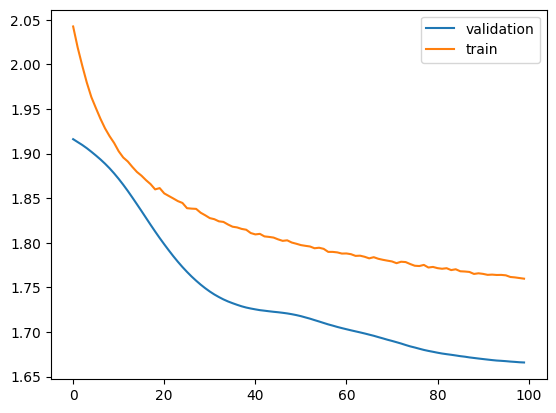

In [8]:
plt.plot(val_losses, label='validation')
plt.plot(train_losses, label='train')
plt.legend()
plt.show()

In [11]:
new_sample = df.sample(n=1)
print(new_sample)
X = new_sample[['dead_fuel_1000', 'energy_release', 'humidity', 'max_temp_C',
        'precipitation', 'wind_speed',
        'population_density', 'vegetation', 'drought_index',  'DOY_sin', 'DOY_cos',
        'LATITUDE', 'LONGITUDE']].values
y = new_sample['FIRE_SIZE_CLASS_NUM'].values - 1  # classes start at 1, shift to 0 for pytorch


# Preprocess
new_sample_scaled = scaler.transform(X)
new_sample_tensor = torch.tensor(new_sample_scaled, dtype=torch.float32)

# Predict
model.eval()
with torch.no_grad():
    output = model(new_sample_tensor)
    print(output)
    predicted_class = output.argmax(dim=1).item()
    predicted_class += 1

print(f"Predicted FIRE_SIZE_CLASS_NUM: {predicted_class}")


       FIRE_YEAR  CONT_DATE  DURATION_DAYS  LATITUDE  LONGITUDE  \
27660       2008  2454675.5            3.0  42.57611 -123.40417   

       DISCOVERY_DOY  dead_fuel_1000  energy_release  humidity  max_temp_C  \
27660            207        7.981804       74.875587  0.005982   30.465234   

       min_temp_C  precipitation  wind_speed  population_density  vegetation  \
27660   10.763849            0.0    3.298044           10.346117      3702.0   

       drought_index  FIRE_SIZE_CLASS_NUM   DOY_sin   DOY_cos  
27660         -1.245                    1 -0.409356 -0.912375  
tensor([[-0.1651, -0.0229,  0.0416, -0.1087, -0.1126,  0.0717,  0.1181]])
Predicted FIRE_SIZE_CLASS_NUM: 7


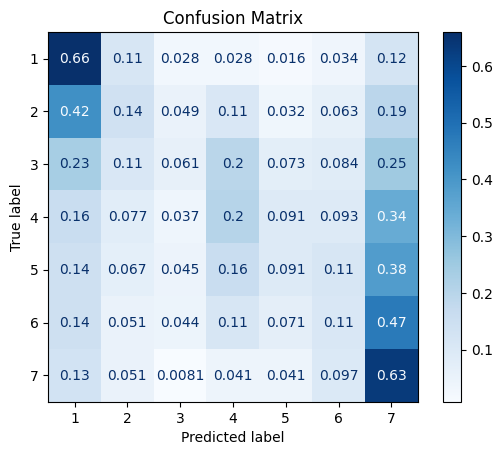

In [12]:

# Predict
model.eval()
with torch.no_grad():
    val_outputs = model(X_val)
    val_preds = val_outputs.argmax(dim=1)

# Shift classes back if necessary
val_preds_shifted = val_preds + 1
y_val_shifted = y_val + 1

# Confusion matrix
cm = confusion_matrix(y_val_shifted.cpu(), val_preds_shifted.cpu(), normalize='true')


# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3,4,5,6,7])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


## svm

In [13]:

# Features and target

X = df[['dead_fuel_1000', 'energy_release', 'humidity', 'max_temp_C',
'precipitation', 'wind_speed',
'population_density', 'vegetation', 'drought_index',  'DOY_sin', 'DOY_cos',
'LATITUDE', 'LONGITUDE']]

y = df['FIRE_SIZE_CLASS_NUM']

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,  stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)


In [14]:

# Automatically balance classes
svm = SVC(class_weight='balanced', probability=True)

# Train
svm.fit(X_train, y_train)


SVC(class_weight='balanced', probability=True)

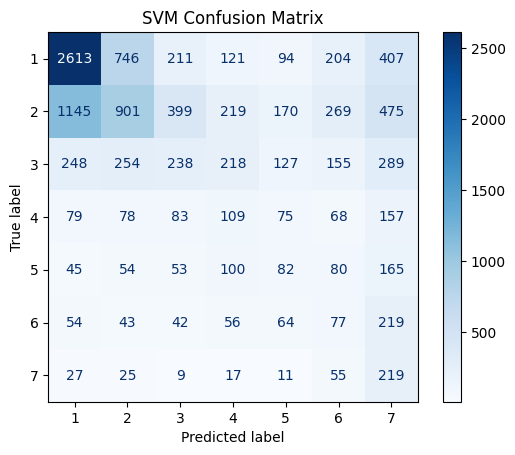

Validation Accuracy: 0.3639


In [15]:

# Predict
y_pred = svm.predict(X_val)

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(y.unique()))
disp.plot(cmap='Blues')
plt.title('SVM Confusion Matrix')
plt.show()

# Accuracy
acc = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {acc:.4f}")


## xgboost


In [16]:


features = ['dead_fuel_1000', 'energy_release', 'humidity', 'max_temp_C',
            'precipitation', 'wind_speed', 'population_density', 'vegetation',
            'drought_index', 'DISCOVERY_DOY', 'LATITUDE', 'LONGITUDE']

df['DOY_sin'] = np.sin(2 * np.pi * df['DISCOVERY_DOY']/365)
df['DOY_cos'] = np.cos(2 * np.pi * df['DISCOVERY_DOY']/365)

# Combine features
features += [ 'DOY_sin', 'DOY_cos']

# Inputs and target
X = df[features].values
y = df['FIRE_SIZE_CLASS_NUM'].values - 1  # Shift class labels to 0-based

# Scale inputs
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,  stratify=y)


<ipython-input-16-dfed7d1c44f8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DOY_sin'] = np.sin(2 * np.pi * df['DISCOVERY_DOY']/365)
<ipython-input-16-dfed7d1c44f8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DOY_cos'] = np.cos(2 * np.pi * df['DISCOVERY_DOY']/365)


[16778 14211  6550  2844  2559  2521  1630]


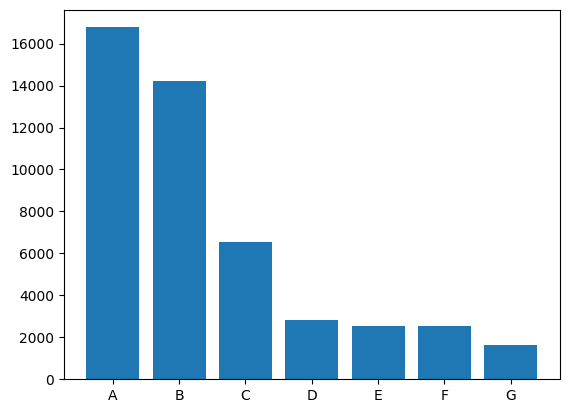

In [38]:
# Class frequencies
class_counts = np.bincount(y_train)
total_samples = len(y_train)
print(class_counts)
plt.bar(['A','B','C','D','E','F','G'], class_counts)
plt.show()
# Inverse frequency
class_weights = total_samples / (len(class_counts) * class_counts)

# Map weight for each sample
sample_weights = np.array([class_weights[label] for label in y_train])


In [18]:

# Create classifier
model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(class_counts),
    eval_metric='mlogloss',
    learning_rate=0.1,
    # n_estimators=200,
    # max_depth=6,
    max_depth=8,
    n_estimators=500  ,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
)



# Fit with sample weights
model.fit(X_train, y_train, sample_weight=sample_weights, eval_set=[(X_val, y_val)], verbose=10)


[0]	validation_0-mlogloss:1.90905


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [21:22:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[10]	validation_0-mlogloss:1.69588
[20]	validation_0-mlogloss:1.60706
[30]	validation_0-mlogloss:1.56305
[40]	validation_0-mlogloss:1.53538
[50]	validation_0-mlogloss:1.51733
[60]	validation_0-mlogloss:1.50527
[70]	validation_0-mlogloss:1.49526
[80]	validation_0-mlogloss:1.48486
[90]	validation_0-mlogloss:1.47619
[100]	validation_0-mlogloss:1.46915
[110]	validation_0-mlogloss:1.46273
[120]	validation_0-mlogloss:1.45700
[130]	validation_0-mlogloss:1.45109
[140]	validation_0-mlogloss:1.44602
[150]	validation_0-mlogloss:1.44054
[160]	validation_0-mlogloss:1.43588
[170]	validation_0-mlogloss:1.43152
[180]	validation_0-mlogloss:1.42816
[190]	validation_0-mlogloss:1.42392
[200]	validation_0-mlogloss:1.42052
[210]	validation_0-mlogloss:1.41740
[220]	validation_0-mlogloss:1.41487
[230]	validation_0-mlogloss:1.41238
[240]	validation_0-mlogloss:1.41123
[250]	validation_0-mlogloss:1.40861
[260]	validation_0-mlogloss:1.40661
[270]	validation_0-mlogloss:1.40419
[280]	validation_0-mlogloss:1.40233
[

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None, num_class=7, ...)

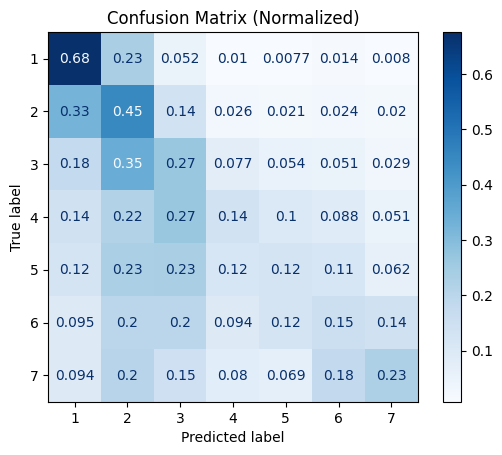

Validation accuracy: 0.4555
              precision    recall  f1-score   support

     Class 1       0.64      0.68      0.66      4396
     Class 2       0.44      0.45      0.45      3578
     Class 3       0.26      0.27      0.26      1529
     Class 4       0.18      0.14      0.15       649
     Class 5       0.17      0.12      0.14       579
     Class 6       0.17      0.15      0.16       555
     Class 7       0.22      0.23      0.22       363

    accuracy                           0.46     11649
   macro avg       0.30      0.29      0.29     11649
weighted avg       0.44      0.46      0.45     11649



In [19]:
# Predict on validation
y_pred = model.predict(X_val)

# Confusion matrix
cm = confusion_matrix(y_val, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(1, len(class_counts)+1))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Normalized)")
plt.show()

# Accuracy and classification report
acc = (y_pred == y_val).mean()
print(f"Validation accuracy: {acc:.4f}")
print(classification_report(y_val, y_pred, target_names=[f"Class {i}" for i in range(1, len(class_counts)+1)]))


# testing for fires that lasted longer than 1 week


In [20]:

df_long = df[df["DURATION_DAYS"]>=7]
df_long


,FIRE_YEAR,CONT_DATE,DURATION_DAYS,LATITUDE,LONGITUDE,DISCOVERY_DOY,dead_fuel_1000,energy_release,humidity,max_temp_C,min_temp_C,precipitation,wind_speed,population_density,vegetation,drought_index,FIRE_SIZE_CLASS_NUM,DOY_sin,DOY_cos
2,2004,2453299.5,15.0,38.523333,-120.211667,280,7.771585,77.266144,0.004487,23.897638,9.720789,0.000000,2.096183,0.000000,2080.0,-3.6375,7,-0.994218,0.107381
12,2005,2453550.5,8.0,33.723333,-111.275000,172,4.648958,76.771233,0.005263,42.077844,27.386774,0.937913,2.593820,0.001369,2674.0,3.0175,7,0.179767,-0.983709
16,2005,2453558.5,10.0,33.330556,-97.762500,178,14.363338,48.132713,0.010137,34.582483,21.067010,0.000000,4.637195,6.781231,2842.0,-1.6950,3,0.077386,-0.997001
45,2005,2453576.5,8.0,33.871111,-111.072500,198,3.812320,101.901382,0.006773,40.943384,21.359705,0.000000,4.360506,0.099544,3576.0,2.0650,5,-0.263665,-0.964614
53,2005,2453551.5,8.0,34.283333,-107.913056,173,6.400099,87.575272,0.005169,28.187585,12.769617,0.000000,3.470685,0.116981,2332.0,2.1075,3,0.162807,-0.986658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61164,2014,2456811.5,8.0,37.568954,-120.141590,146,9.254385,72.484756,0.005507,34.249292,14.483728,0.000000,4.372144,3.276676,2449.0,-4.6950,5,0.587785,-0.809017
61165,2014,2456909.5,41.0,39.833208,-123.631965,211,7.931626,79.097771,0.006470,32.602960,17.875391,0.000000,4.313021,1.268675,4478.0,-4.4400,7,-0.471160,-0.882048
61169,2009,2455052.5,7.0,40.913002,-121.206994,214,7.396139,57.570179,0.007142,31.070825,11.545587,0.919065,3.630244,0.496303,1683.0,-2.5250,3,-0.516062,-0.856551
61179,2015,2457292.5,8.0,36.391049,-121.595123,262,11.025095,58.629074,0.006397,33.033563,16.081140,0.000000,4.451148,0.623965,1970.0,-2.2650,6,-0.979614,-0.200891


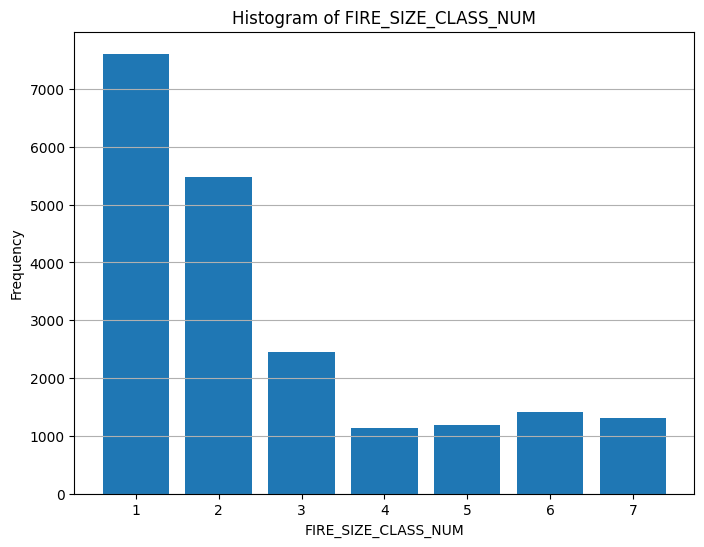

In [21]:
import matplotlib.pyplot as plt

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(df_long['FIRE_SIZE_CLASS_NUM'], bins=range(int(df_long['FIRE_SIZE_CLASS_NUM'].min()), int(df_long['FIRE_SIZE_CLASS_NUM'].max()) + 2), align='left', rwidth=0.8)
plt.xlabel('FIRE_SIZE_CLASS_NUM')
plt.ylabel('Frequency')
plt.title('Histogram of FIRE_SIZE_CLASS_NUM')
plt.xticks(sorted(df_long['FIRE_SIZE_CLASS_NUM'].unique()))
plt.grid(axis='y')

plt.show()


In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Original features
features = ['dead_fuel_1000', 'energy_release', 'humidity', 'max_temp_C',
            'precipitation', 'wind_speed', 'population_density', 'vegetation',
            'drought_index', 'DISCOVERY_DOY', 'LATITUDE', 'LONGITUDE',]

# Optional engineered features
df_long['DOY_sin'] = np.sin(2 * np.pi * df_long['DISCOVERY_DOY']/365)
df_long['DOY_cos'] = np.cos(2 * np.pi * df_long['DISCOVERY_DOY']/365)

# Combine features
features += [ 'DOY_sin', 'DOY_cos']


features = ['dead_fuel_1000', 'energy_release', 'humidity', 'max_temp_C',
            'precipitation', 'wind_speed', 'population_density', 'vegetation',
            'drought_index', 'DISCOVERY_DOY', 'LATITUDE',
            'LONGITUDE',  'DOY_sin', 'DOY_cos']



# Inputs and target
X = df_long[features].values
y = df_long['FIRE_SIZE_CLASS_NUM'].values - 1  # Shift class labels to 0-based

# Scale inputs
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


<ipython-input-22-d4fe9b7b0249>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_long['DOY_sin'] = np.sin(2 * np.pi * df_long['DISCOVERY_DOY']/365)
<ipython-input-22-d4fe9b7b0249>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_long['DOY_cos'] = np.cos(2 * np.pi * df_long['DISCOVERY_DOY']/365)


In [23]:
# Class frequencies
class_counts = np.bincount(y_train)
total_samples = len(y_train)

# Inverse frequency
class_weights = total_samples / (len(class_counts) * class_counts)

# Map weight for each sample
sample_weights = np.array([class_weights[label] for label in y_train])

In [24]:
import xgboost as xgb

# Create classifier
model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(class_counts),
    eval_metric='mlogloss',
    learning_rate=0.1,
    # n_estimators=200,
    # max_depth=6,
    max_depth=8,
    n_estimators=500  ,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    random_state=42
)



# Fit with sample weights
model.fit(X_train, y_train, sample_weight=sample_weights, eval_set=[(X_val, y_val)], verbose=10)


[0]	validation_0-mlogloss:1.90015


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [21:23:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[10]	validation_0-mlogloss:1.68329
[20]	validation_0-mlogloss:1.60500
[30]	validation_0-mlogloss:1.56367
[40]	validation_0-mlogloss:1.53989
[50]	validation_0-mlogloss:1.52778
[60]	validation_0-mlogloss:1.51786
[70]	validation_0-mlogloss:1.51001
[80]	validation_0-mlogloss:1.50436
[90]	validation_0-mlogloss:1.49737
[100]	validation_0-mlogloss:1.49106
[110]	validation_0-mlogloss:1.48713
[120]	validation_0-mlogloss:1.48275
[130]	validation_0-mlogloss:1.47852
[140]	validation_0-mlogloss:1.47488
[150]	validation_0-mlogloss:1.47489
[160]	validation_0-mlogloss:1.47435
[170]	validation_0-mlogloss:1.47252
[180]	validation_0-mlogloss:1.47052
[190]	validation_0-mlogloss:1.47080
[200]	validation_0-mlogloss:1.47146
[210]	validation_0-mlogloss:1.47333
[220]	validation_0-mlogloss:1.47492
[230]	validation_0-mlogloss:1.47646
[240]	validation_0-mlogloss:1.47752
[250]	validation_0-mlogloss:1.48016
[260]	validation_0-mlogloss:1.48290
[270]	validation_0-mlogloss:1.48511
[280]	validation_0-mlogloss:1.48883
[

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None, num_class=7, ...)

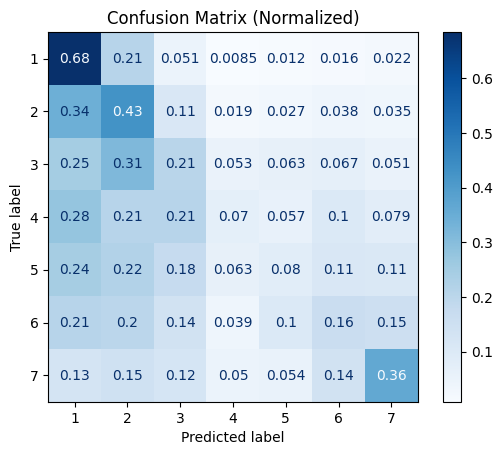

Validation accuracy: 0.4340
              precision    recall  f1-score   support

     Class 1       0.60      0.68      0.64      1522
     Class 2       0.41      0.43      0.42      1094
     Class 3       0.22      0.21      0.21       490
     Class 4       0.14      0.07      0.09       227
     Class 5       0.12      0.08      0.10       237
     Class 6       0.20      0.16      0.18       284
     Class 7       0.34      0.36      0.35       261

    accuracy                           0.43      4115
   macro avg       0.29      0.28      0.28      4115
weighted avg       0.41      0.43      0.42      4115



In [25]:
# Predict on validation
y_pred = model.predict(X_val)

# Confusion matrix
cm = confusion_matrix(y_val, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(1, len(class_counts)+1))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Normalized)")
plt.show()

# Accuracy and classification report
acc = (y_pred == y_val).mean()
print(f"Validation accuracy: {acc:.4f}")
print(classification_report(y_val, y_pred, target_names=[f"Class {i}" for i in range(1, len(class_counts)+1)]))


In [26]:
print(*features)

dead_fuel_1000 energy_release humidity max_temp_C precipitation wind_speed population_density vegetation drought_index DISCOVERY_DOY LATITUDE LONGITUDE DOY_sin DOY_cos


# compare correlational models with only

In [27]:
df['temp_C'] = (df['min_temp_C'] + df['max_temp_C'])/2


features = [ 'humidity', 'temp_C',
            'precipitation', 'wind_speed', 'population_density', 'vegetation',
            'drought_index']


# Inputs and target
X = df[features].values
y = df['FIRE_SIZE_CLASS_NUM'].values - 1  # Shift class labels to 0-based

# Scale inputs
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,  stratify=y)


<ipython-input-27-d9e157f5caf6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temp_C'] = (df['min_temp_C'] + df['max_temp_C'])/2


In [28]:
# Class frequencies
class_counts = np.bincount(y_train)
total_samples = len(y_train)

# Inverse frequency
class_weights = total_samples / (len(class_counts) * class_counts)

# Map weight for each sample
sample_weights = np.array([class_weights[label] for label in y_train])


In [29]:

# Create classifier
model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(class_counts),
    eval_metric='mlogloss',
    learning_rate=0.1,
    # n_estimators=200,
    # max_depth=6,
    max_depth=8,
    n_estimators=500  ,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
)



# Fit with sample weights
model.fit(X_train, y_train, sample_weight=sample_weights, eval_set=[(X_val, y_val)], verbose=10)


[0]	validation_0-mlogloss:1.92176


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [21:23:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[10]	validation_0-mlogloss:1.78171
[20]	validation_0-mlogloss:1.71991
[30]	validation_0-mlogloss:1.68860
[40]	validation_0-mlogloss:1.66928
[50]	validation_0-mlogloss:1.65781
[60]	validation_0-mlogloss:1.64930
[70]	validation_0-mlogloss:1.64221
[80]	validation_0-mlogloss:1.63652
[90]	validation_0-mlogloss:1.63100
[100]	validation_0-mlogloss:1.62601
[110]	validation_0-mlogloss:1.62143
[120]	validation_0-mlogloss:1.61712
[130]	validation_0-mlogloss:1.61285
[140]	validation_0-mlogloss:1.60881
[150]	validation_0-mlogloss:1.60484
[160]	validation_0-mlogloss:1.60123
[170]	validation_0-mlogloss:1.59775
[180]	validation_0-mlogloss:1.59388
[190]	validation_0-mlogloss:1.59002
[200]	validation_0-mlogloss:1.58663
[210]	validation_0-mlogloss:1.58363
[220]	validation_0-mlogloss:1.57995
[230]	validation_0-mlogloss:1.57624
[240]	validation_0-mlogloss:1.57386
[250]	validation_0-mlogloss:1.57096
[260]	validation_0-mlogloss:1.56840
[270]	validation_0-mlogloss:1.56630
[280]	validation_0-mlogloss:1.56367
[

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None, num_class=7, ...)

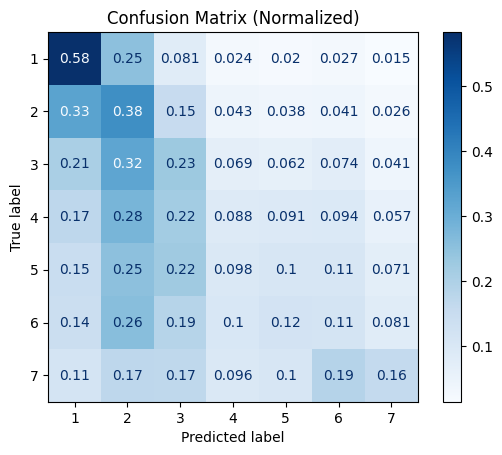

Validation accuracy: 0.3857
              precision    recall  f1-score   support

     Class 1       0.59      0.58      0.59      4396
     Class 2       0.39      0.38      0.38      3578
     Class 3       0.21      0.23      0.22      1529
     Class 4       0.10      0.09      0.09       649
     Class 5       0.11      0.10      0.11       579
     Class 6       0.10      0.11      0.11       555
     Class 7       0.15      0.16      0.15       363

    accuracy                           0.39     11649
   macro avg       0.23      0.24      0.23     11649
weighted avg       0.39      0.39      0.39     11649



In [30]:
# Predict on validation
y_pred = model.predict(X_val)

# Confusion matrix
cm = confusion_matrix(y_val, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(1, len(class_counts)+1))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Normalized)")
plt.show()

# Accuracy and classification report
acc = (y_pred == y_val).mean()
print(f"Validation accuracy: {acc:.4f}")
print(classification_report(y_val, y_pred, target_names=[f"Class {i}" for i in range(1, len(class_counts)+1)]))


# generalization (train prior 2014)


### xgboost

In [31]:


features = ['dead_fuel_1000', 'energy_release', 'humidity', 'max_temp_C',
            'precipitation', 'wind_speed', 'population_density', 'vegetation',
            'drought_index', 'DISCOVERY_DOY', 'LATITUDE', 'LONGITUDE']

df['DOY_sin'] = np.sin(2 * np.pi * df['DISCOVERY_DOY']/365)
df['DOY_cos'] = np.cos(2 * np.pi * df['DISCOVERY_DOY']/365)

# Combine features
features += [ 'DOY_sin', 'DOY_cos']

scaler = StandardScaler()
X = scaler.fit_transform(X)


# Inputs and target
X_val = df[df['FIRE_YEAR'] >= 2014][features].values
X_train = df[df['FIRE_YEAR'] < 2014][features].values
y_val = df[df['FIRE_YEAR'] >= 2014]['FIRE_SIZE_CLASS_NUM'].values - 1  # Shift class labels to 0-based
y_train = df[df['FIRE_YEAR'] < 2014]['FIRE_SIZE_CLASS_NUM'].values - 1  # Shift class labels to 0-based



<ipython-input-31-3e9181592721>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DOY_sin'] = np.sin(2 * np.pi * df['DISCOVERY_DOY']/365)
<ipython-input-31-3e9181592721>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DOY_cos'] = np.cos(2 * np.pi * df['DISCOVERY_DOY']/365)


[16778 14211  6550  2844  2559  2521  1630]


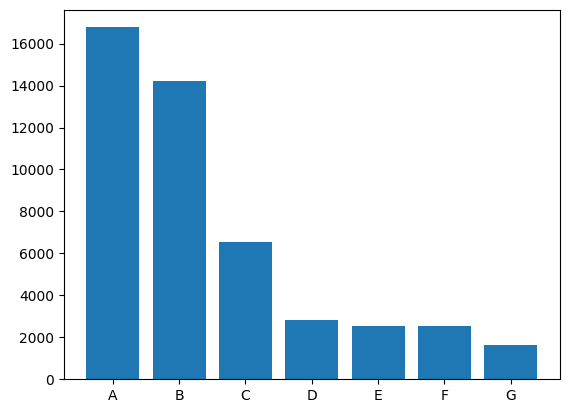

In [37]:
# Class frequencies
class_counts = np.bincount(y_train)
total_samples = len(y_train)
print(class_counts)
plt.bar(['A','B','C','D','E','F','G'], class_counts)
plt.show()
# Inverse frequency
class_weights = total_samples / (len(class_counts) * class_counts)

# Map weight for each sample
sample_weights = np.array([class_weights[label] for label in y_train])


In [33]:

# Create classifier
model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(class_counts),
    eval_metric='mlogloss',
    learning_rate=0.1,
    # n_estimators=200,
    # max_depth=6,
    max_depth=8,
    n_estimators=500  ,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
)



# Fit with sample weights
model.fit(X_train, y_train, sample_weight=sample_weights, eval_set=[(X_val, y_val)], verbose=10)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [21:24:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[0]	validation_0-mlogloss:1.88999
[10]	validation_0-mlogloss:1.57475
[20]	validation_0-mlogloss:1.44956
[30]	validation_0-mlogloss:1.38900
[40]	validation_0-mlogloss:1.35178
[50]	validation_0-mlogloss:1.32883
[60]	validation_0-mlogloss:1.31297
[70]	validation_0-mlogloss:1.30191
[80]	validation_0-mlogloss:1.29369
[90]	validation_0-mlogloss:1.28668
[100]	validation_0-mlogloss:1.28034
[110]	validation_0-mlogloss:1.27457
[120]	validation_0-mlogloss:1.26864
[130]	validation_0-mlogloss:1.26412
[140]	validation_0-mlogloss:1.26031
[150]	validation_0-mlogloss:1.25604
[160]	validation_0-mlogloss:1.25373
[170]	validation_0-mlogloss:1.24970
[180]	validation_0-mlogloss:1.24651
[190]	validation_0-mlogloss:1.24331
[200]	validation_0-mlogloss:1.24005
[210]	validation_0-mlogloss:1.23653
[220]	validation_0-mlogloss:1.23462
[230]	validation_0-mlogloss:1.23241
[240]	validation_0-mlogloss:1.22959
[250]	validation_0-mlogloss:1.22777
[260]	validation_0-mlogloss:1.22614
[270]	validation_0-mlogloss:1.22331
[28

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None, num_class=7, ...)

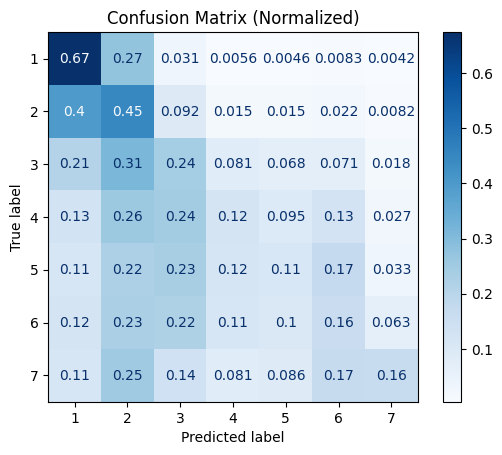

Validation accuracy: 0.5004
              precision    recall  f1-score   support

     Class 1       0.66      0.67      0.67      5197
     Class 2       0.45      0.45      0.45      3678
     Class 3       0.26      0.24      0.25      1095
     Class 4       0.16      0.12      0.14       402
     Class 5       0.13      0.11      0.12       335
     Class 6       0.10      0.16      0.13       255
     Class 7       0.21      0.16      0.18       186

    accuracy                           0.50     11148
   macro avg       0.28      0.27      0.28     11148
weighted avg       0.50      0.50      0.50     11148



In [34]:
# Predict on validation
y_pred = model.predict(X_val)

# Confusion matrix
cm = confusion_matrix(y_val, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(1, len(class_counts)+1))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Normalized)")
plt.show()

# Accuracy and classification report
acc = (y_pred == y_val).mean()
print(f"Validation accuracy: {acc:.4f}")
print(classification_report(y_val, y_pred, target_names=[f"Class {i}" for i in range(1, len(class_counts)+1)]))
